# Classification based anomaly detection

Name: Benjamin Fraeyman

It is possible that when creating a system to detect anomalies, the dataset at hand will have a few samples of the anomalies. For example, microcalcifications in mammographic images (i.e. small calcium deposits that develop in a woman's breast tissue) are rare and should be detectable as they are this is the first step required to detect malignancy. Datasets exist containing data from both healthy mammographic images and non-healthy mammographic images. However, within those datasets there are many more samples of the healthy mammographic images.


Within this lab exercise our goal is to create a classifier that can deal with this class skew/unbalance and detect anomalies in mammographic images.

---

Imports

In [1]:
# ![My Title](mammography.png)
%matplotlib inline
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, precision_score, accuracy_score
import numpy as np
np.random.seed(0)
from numpy.random import choice
from sklearn.utils import resample
from scipy.stats import mode
from sklearn import tree
import matplotlib.pylab as plt

# to clear output after long list of checks that were printed out :)
from IPython.display import clear_output # used in last codeblock to remove all the prints from my functions

C:\ProgramData\Anaconda2\envs\pyth36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


---

**Load the training, testing and validation set together with their respective class labels).**

- training set: df_training_X and df_training_y
- validation set: df_validation_X and df_validation_y
- testing set: df_testing_X and df_testing_y


In [2]:
df_training_X = pd.read_csv('./df_training_X', sep=",")
df_training_y = pd.read_csv('./df_training_y', sep=",")
df_validation_X = pd.read_csv('./df_validation_X', sep=",")
df_validation_y = pd.read_csv('./df_validation_y', sep=",")
df_testing_X = pd.read_csv('./df_testing_X', sep=",")
df_testing_y = pd.read_csv('./df_testing_y', sep=",")

**Inspect the data**

In [3]:
df_training_y.head(1)

,Label
0,0


- What is the shape of the training set?

In [4]:
df_training_X.shape

(6709, 6)

- How many samples of class 0 and 1 are there in the training set?

In [5]:
df_training_y.Label.value_counts()

0    6553
1     156
Name: Label, dtype: int64

---

We will first set a baseline to see how well an everyday classifier works.
**Create a random forest classifier and train it on the training set. The random forest should have 50 trees.** 
Tip: fix the random_state of your RandomForestClassifier 

https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1

In [6]:
clf = RandomForestClassifier(n_estimators=50, random_state=0)
clf.fit(df_training_X, df_training_y)

C:\ProgramData\Anaconda2\envs\pyth36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

---

**Evaluate how well the classifier works by predicting for the training, validation and testing set. For all 3 datasets, make sure you report the precision, recall, f1 score, accuracy and the confusion matrix.**

Hint: create a re-usable function that provides you with these scores.

In [7]:
def prediction(df_to_predict_on, model, df_labels):
    predicted_labels = model.predict(df_to_predict_on)
    print("\trecall_score:", "%.2f" % (recall_score(df_labels, predicted_labels)*100), "%")
    print("\taccuracy_score:", "%.2f" % (accuracy_score(df_labels, predicted_labels)*100), "%")
    print("\tprecision_score:", "%.2f" % (precision_score(df_labels, predicted_labels)*100), "%")
    print("\tf1_score:", "%.2f" % (f1_score(df_labels, predicted_labels)*100), "%")
    print("\tconfusion_matrix:")
    print("\t\t",confusion_matrix(df_labels, predicted_labels)[0])
    print("\t\t",confusion_matrix(df_labels, predicted_labels)[1])
    print("")

# to just get f1 score
def prediction_f1(df_to_predict_on, model, df_labels):
    predicted_labels = model.predict(df_to_predict_on)
    f1 = f1_score(df_labels, predicted_labels)
    print("\tf1_score:",f1)
    return f1

In [8]:
print("df_training_X:")
prediction(df_training_X, clf, df_training_y)

df_training_X:
	recall_score: 97.44 %
	accuracy_score: 99.94 %
	precision_score: 100.00 %
	f1_score: 98.70 %
	confusion_matrix:
		 [6553    0]
		 [  4 152]



In [9]:
print("df_validation_X:")
prediction(df_validation_X, clf, df_validation_y)

df_validation_X:
	recall_score: 53.85 %
	accuracy_score: 98.75 %
	precision_score: 87.50 %
	f1_score: 66.67 %
	confusion_matrix:
		 [2181    4]
		 [24 28]



In [10]:
print("df_testing_X:")
prediction(df_testing_X, clf, df_testing_y) 

df_testing_X:
	recall_score: 44.23 %
	accuracy_score: 98.57 %
	precision_score: 88.46 %
	f1_score: 58.97 %
	confusion_matrix:
		 [2182    3]
		 [29 23]



---

**Reflect on how well this classifier works:** 
    - Why does the classifier achieve a low recall?
> The classifier is very picky: It does not think many things are correct. It does not classify all "true" cases as "true" (rather says it is "wrong" then have false positives).

    - Why is the precision high?
> Most guesses it classifies as "true" are actually "true".

    - Why is the accuracy so high?
> looking at the confusion matrix you can see that there are not a lot of "true" cases, thus when the classifier puts most guesses as "false" that means most of them are accurate. (the percentage of correct negatives is not affected a lot because of a small amount of false negatives)
    
    Source: https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9
---

To deal with the imbalance in the dataset we will create a modified version of the random forest algorithm called
["Balanced Random Forest"](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf).

The essence of the algorithm is the following:

1. For each iteration in random forest, draw a bootstrap sample from the minority class. Randomly draw
the same number of cases, with replacement, from the majority class.

2. Induce a classification tree from the data to maximum size, without pruning. The tree is created with the following modification: At each node, instead of searching through all
variables for the optimal split, only search through a set of k randomly selected variables. (k= $\sqrt{\text{total number of features}}$). (scikit-learn's DecisionTreeClassifier can do this all)

3. Repeat the two steps above for the number of times desired. Aggregate the predictions of the ensemble
and make the final prediction.

**Create a python class called `BalancedRandomForest`. This class should have a `fit` and `predict` function (following the scikit-learn api interface). Within the fit function, the above steps should be implemented. The goal is to create several decision trees that are trained on a balanced subset of the data. Within the predict function you should make a prediction for every decision tree and do majority voting per sample.**

**Make sure that your constructor has the number of trees as parameter, but also a parameter called ratio. The ratio parameter indicates how much of the majority samples should be kept in the subset. More precisly, it is used as follow: number of samples to draw from the majority class = ratio * numbers of samples in the minority class. This means that if you set the ratio to 1, you should get a balanced subset. If you set the ratio equal to 2, then you should have twice as many majority samples than minority samples.**

Tip: fix the random_state of your DecisionTreeClassifier

![My Title](https://www.svds.com/wp-content/uploads/2016/08/ImbalancedClasses_fig9.png)

In [11]:
# https://javadoc.scijava.org/Fiji/ai/BalancedRandomForest.html
# https://qiita.com/kyo-bad/items/0f6faf5629f6c563d36f
from typing import Set, Any
def remove_others(df, columns: Set[Any]):
    cols_total: Set[Any] = set(df.columns)
    diff: Set[Any] = cols_total - columns
    df.drop(diff, axis=1, inplace=True)
    return df

class BalancedRandomForest():
    def __init__(self, n_trees, n_samples, ratio):
        self.n_trees = n_trees
        self.n_samples = n_samples
        self.trees = []
        self.ratio = ratio
        
    def fit(self, dfx, dfy):
        dfmerged = pd.concat([dfx, dfy], axis = 1)
        df1 = dfmerged[dfy.Label == 1]
        df0 = dfmerged[dfy.Label == 0]
        for i in range(0, self.n_trees):
            self.trees.append(tree.DecisionTreeClassifier(random_state = 0, max_features = 'sqrt'))
            bootstrapsample0 = df0.sample(replace = True, n = self.n_samples * self.ratio, random_state = 0)
            bootstrapsample1 = df1.sample(replace = True, n = self.n_samples, random_state = 0)
            balancesample0 = bootstrapsample0.sample(replace = False, n = self.n_samples, random_state = 0)
            balancesample1 = bootstrapsample1.sample(replace = False, n = self.n_samples, random_state = 0)
            dfmergedsamples = balancesample0.append(balancesample1)
            resultingX = dfmergedsamples.drop("Label", axis=1)
            resultingy = remove_others(dfmergedsamples, {"Label"})
            self.trees[i].fit(resultingX, resultingy)

    def predict(self, testX):
        results = []
        for i in range(0, self.n_trees):
            results.append(self.trees[i].predict(testX))
        return mode(results)[0][0]

---

**Train your BalancedRandomForest using 50 trees on the training set and set the ratio such that you create balanced subsets in your algorithm.**

In [12]:
brf = BalancedRandomForest(n_trees = 50, n_samples = df_training_y[df_training_y.Label == 1].shape[0], ratio = 1)
brf.fit(df_training_X, df_training_y)
print(brf.predict(df_training_X))

[0 1 0 ... 0 1 1]


---

**Evaluate how well the algorithm works for the training, validation and testing set.**

In [13]:
prediction(df_training_X, brf, df_training_y)

	recall_score: 91.67 %
	accuracy_score: 87.58 %
	precision_score: 14.85 %
	f1_score: 25.56 %
	confusion_matrix:
		 [5733  820]
		 [ 13 143]



In [14]:
prediction(df_validation_X, brf, df_validation_y)

	recall_score: 76.92 %
	accuracy_score: 88.11 %
	precision_score: 13.61 %
	f1_score: 23.12 %
	confusion_matrix:
		 [1931  254]
		 [12 40]



In [15]:
prediction(df_testing_X, brf, df_testing_y)

	recall_score: 90.38 %
	accuracy_score: 85.70 %
	precision_score: 12.98 %
	f1_score: 22.71 %
	confusion_matrix:
		 [1870  315]
		 [ 5 47]



**We can see that the recall has increased a lot, but the precision has lowered. Why is this?**
> Recall did not increase in my case.<br/> Precision did get lower. Low precision could be because the optimal combination of trees and ratio is not used. The set is balanced but our data is not and we do not take this into account.

---

**Do a gridsearch to find the optimal number of trees in your balanced random forest and also to find the optimal ratio.** 

This means that you should increase your ratio such that the subsets contain 2x, 3x, 4x,... as many majority samples compared to the minority samples. <br/>
Do this up untill a ratio of 42. <br/>
Additionally, to find the optimal number of trees, start with 1 tree and increase the number of trees untill you have 500 trees (you can do this in steps of 50 trees). <br/>
The grid search should be executed on the validation set (i.e. training should happen on the training set and evaluation on the validation set). <br/>
The evaluation metric you should optimize is the f1-score.<br/>
Report the optimal hyperparameters below.

In [16]:
s = 0
trees = 0
ratio = 0
score_list = []
for r in range(2, 43):
    print("ratio:",r)
    for t in range(1, 502, 50):
        print("\ttrees:",t)
        bestBRF = BalancedRandomForest(n_trees = t, n_samples = df_training_y[df_training_y.Label == 1].shape[0], ratio = r)
        bestBRF.fit(df_training_X, df_training_y)
        score = prediction_f1(df_validation_X, bestBRF, df_validation_y)
        score_list.append(score)
        if(score > s):
            s = score
            trees = t
            ratio = r
    clear_output(wait=True)
print("score:", "%.2f" % (s*100), "%")
print("ratio: ", ratio)
print("trees: ", trees)

score: 26.84 %
ratio:  24
trees:  1


---

**Finally, using your best model, predict for the testing set.**

In [17]:
bestBRF = BalancedRandomForest(n_trees = trees, n_samples = df_training_y[df_training_y.Label == 1].shape[0], ratio = ratio)
bestBRF.fit(df_training_X, df_training_y)
prediction(df_testing_X, bestBRF, df_testing_y)

	recall_score: 90.38 %
	accuracy_score: 89.58 %
	precision_score: 17.09 %
	f1_score: 28.75 %
	confusion_matrix:
		 [1957  228]
		 [ 5 47]



**What do you observe?**
> High recall and high accuracy but low precision and low f1

**Plot the f1-scores of your gridsearch in an image as you have done for the SVM lab session**

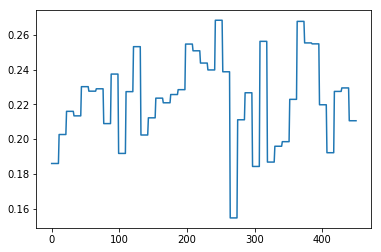

In [18]:
plt.plot(score_list)
plt.show()

Extra source: https://github.com/mainkoon81/Study-09-MachineLearning-A